In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [30]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])).astype('int')
Ni[1] = (np.sum(Ni0[4:8])).astype('int')
Ni[2] = (np.sum(Ni0[8:12])).astype('int')
Ni[3] = (np.sum(Ni0[12:16])).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.UK()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))

for i in range(16):
    CH0[i,:] = CH0[i,:]*Ni0[i]
    CW0[i,:] = CW0[i,:]*Ni0[i]
    CS0[i,:] = CS0[i,:]*Ni0[i]
    CO0[i,:] = CO0[i,:]*Ni0[i]


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )/Ni[i]
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )/Ni[i]
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )/Ni[i]
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )/Ni[i]
        
N = N/5e2
Ni = Ni/5e2

In [31]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.7, 0.6, 0.5

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [32]:
beta  = 0.02      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*100
Is_0[1] += 100 #make one group different 
Ia_0 = np.ones((M))*20
Ia_0[1] += 20
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

contactMatrix=C

# start simulation
Tf=80;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)
np.save('cal_lat_SIR_traj.npy', data['X'])

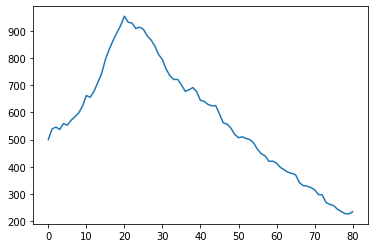

In [33]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.show() 

### Compare the deterministic trajectory and the stochastic one before intervention

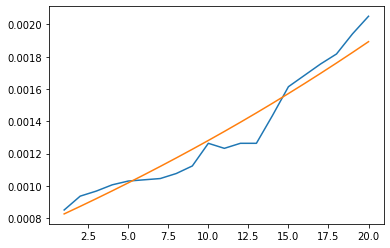

In [34]:
Tf_initial = 20 # truncate to only getting the first few datapoints 
Nf_initial = Tf_initial+1

x = np.load('cal_lat_SIR_traj.npy')
x = (x/N)[:Nf_initial]
steps = 101 # number internal integration steps taken

fltr=np.repeat(np.array([False, False, True]), M)
obs=x[:, fltr] 

contactMatrix = generator.constant_contactMatrix()
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)
xm,full_cov = estimator.obtain_full_mean_cov(x[0], Tf_initial, Nf_initial, det_model, contactMatrix)
t = np.linspace(1, Tf_initial, Nf_initial-1)
plt.plot(t, x[1:,2*M])
plt.plot(t, xm[:,2*M])
plt.show()

In [35]:
# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x[0], obs[1:], fltr, Tf_initial, Nf_initial, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-683.4528840211714
0.15412425994873047


In [36]:
# take a guess 
# beta_g = 0.005
# gIa_g = 0.15
# gIs_g = 0.15
# alpha_g = 0.25
# guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])


eps = 1e-3 # step used to calculate hessian in the optimisation algorithm 

alpha_g = 0.2
alpha_std=0.1
alpha_bounds = (0.1, 0.4)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std=0.02
beta_bounds = (1e-3, 0.2)

gIa_g = 0.145
gIa_std = 0.01
gIa_bounds = (0.10, 0.16)

gIs_g = 0.145
gIs_std = 0.01
gIs_bounds = (0.10, 0.16) 

fsa_g = 0.8

Is0_g = Is_0/N 
Is_std = Is0_g * 0.4
bounds_for_Is = [(60/N, 140/N)]*M
bounds_for_Is[1] = (160/N, 240/N)

Ia0_g = Ia_0/N
Ia_std = Ia0_g * 0.4
bounds_for_Ia = [(10/N, 30/N)]*M
bounds_for_Ia[1] = (30/N, 50/N)


S0_g = S_0/N
S_std = Ia_std*np.sqrt(3)
bounds_for_S = [(fi[i]-400/N, fi[i]-bounds_for_Is[i][0]/N) for i in range(M)]


# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)  
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, *S_std, *Ia_std, *Is_std])
params = estimator.latent_inference(guess, stds, obs, fltr, Tf_initial, Nf_initial, generator.constant_CM,
                                    bounds, beta_rescale=1, verbose=True, ftol=ftol, eps=eps,
                                    global_max_iter=25, cma_population=32, global_ftol_factor=100)

Starting global minimisation...
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 16 (seed=409718, Fri May  1 10:08:37 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 -6.476561765987977e+02 1.0e+00 9.66e-01  2e-05  3e-02 0:06.0
    2     64 -7.424823691557009e+02 1.2e+00 1.07e+00  2e-05  4e-02 0:11.2
    3     96 -7.746522310124928e+02 1.3e+00 1.25e+00  3e-05  4e-02 0:16.1
    4    128 -7.877272185864092e+02 1.4e+00 1.46e+00  3e-05  5e-02 0:20.6
    5    160 -7.855450736429775e+02 1.4e+00 1.66e+00  3e-05  5e-02 0:25.0
    7    224 -7.871478273283105e+02 1.5e+00 1.51e+00  3e-05  5e-02 0:33.8
    9    288 -7.865651577687036e+02 1.7e+00 1.51e+00  3e-05  5e-02 0:42.7
   11    352 -7.891599417489986e+02 1.8e+00 1.33e+00  3e-05  4e-02 0:51.9
   13    416 -7.884354261474955e+02 2.1e+00 1.12e+00  2e-05  4e-02 1:00.5
   16    512 -7.886839609242867e+02 2.6e+00 9.70e-01  2e-05  3e-02 1:13.4
   19    608 -7.888608624714818e+02 3.1e+00 1.02e+00  2e-05  3e

In [37]:
# save the parameters 
np.save('SIR_cal_lat_param.npy', params)

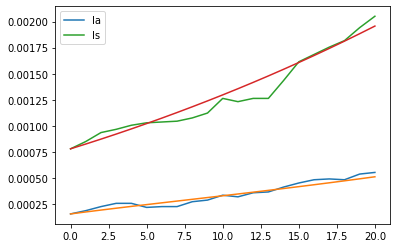

In [38]:
# check the predictions 
params = np.load('SIR_cal_lat_param.npy')
x = np.load('cal_lat_SIR_traj.npy')/N
parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3],'fsa':0.8}
estimator.set_params(parameters)
x0 = params[4:]
det_model = pyross.deterministic.SIR(parameters, M, fi)
contactMatrix = generator.constant_contactMatrix()
x_det = estimator.integrate(x0, 0, Tf_initial, Nf_initial, det_model, contactMatrix)
plt.plot(x[:Nf_initial,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:Nf_initial,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

In [39]:
aW_g = 0.6 
aW_bounds = [0.2, 0.8]
aS_g = 0.6
aS_bounds = [0.2, 0.8]
aO_g = 0.6
aO_bounds = [0.2, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])
stds = np.array([0.1, 0.05, 0.15])

x = np.load('cal_lat_SIR_traj.npy')/N
x = x[Nf_initial:]
obs = x[:, fltr]
Nf_control = x.shape[0] 
Tf_control = Nf_control-1 

det_model = pyross.deterministic.SIR(parameters, M, fi)
contactMatrix = generator.constant_contactMatrix()
x0 = estimator.integrate(params[-3*M:], 0, Tf_initial, 2, det_model, contactMatrix)[-1]
x0 = np.array(x0)
times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
parameters = estimator.make_params_dict(params)
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_control, Nf_control, contactMatrix)
print(logp) 

-2050.721258290064


In [ ]:
eps = 1e-3 
start_time = time.time() 

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters) 
control_params = estimator.latent_infer_control(guess, stds, x0, obs, fltr, Tf_control, Nf_control, generator, bounds,
                                  global_max_iter=20, eps=eps, verbose=True)
end_time = time.time()
print(control_params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 3 (seed=477486, Fri May  1 10:11:44 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -2.054268318806844e+03 1.0e+00 9.24e-01  5e-02  6e-02 0:06.8
    2     32 -2.054698007475798e+03 1.6e+00 8.73e-01  5e-02  5e-02 0:13.9
    3     48 -2.054723625677590e+03 1.9e+00 7.34e-01  3e-02  4e-02 0:21.3
    4     64 -2.054520586403812e+03 2.4e+00 5.42e-01  2e-02  3e-02 0:28.2
    5     80 -2.054781243003826e+03 2.6e+00 4.86e-01  2e-02  2e-02 0:35.1
    6     96 -2.054768723589617e+03 2.8e+00 3.78e-01  1e-02  2e-02 0:41.8
    7    112 -2.054745658289927e+03 2.9e+00 3.06e-01  9e-03  1e-02 0:48.8
    9    144 -2.054789902263191e+03 3.0e+00 2.10e-01  5e-03  6e-03 1:02.5
   11    176 -2.054797198888516e+03 3.2e+00 1.74e-01  3e-03  4e-03 1:15.9
   13    208 -2.054795795387569e+03 2.6e+00 1.32e-01  2e-03  2e-03 1:29.6
   15    240 -2.054798041241307e+03 2.2e+00 1.00e-01  9e-04  1e-0

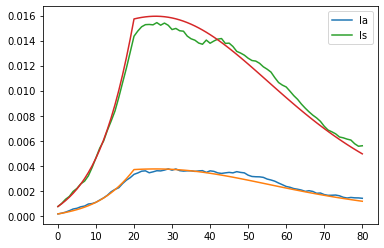

In [40]:
times = [20]
interventions = [[1.0,1.0,1.0],      # before first time
                 control_params,       # after first time
                ]         

# compare the true trajectory with the 
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
det_model = pyross.deterministic.SIR(parameters, M, fi)
x0 = params[4:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('cal_lat_SIR_traj.npy')/N
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()